# Health Insurance Claim Probability Prediction

- Perform EDA on data
- Handle mixed feature types and imbalance
- Train separate models and ensemble
- Optimize Normalized Gini
- Validate on unseen data
- Predict probability of target = 1 on test data and generate submission.csv.

## Imports & Global Configuration

In [18]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import lightgbm as lgb
from catboost import CatBoostClassifier

from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, accuracy_score
import shap
from sklearn.impute import SimpleImputer
from sklearn.metrics import RocCurveDisplay, confusion_matrix
from scipy.stats import spearmanr

import warnings
warnings.filterwarnings("ignore")


In [19]:
TRAIN_FILE = "training_data.csv"
TEST_FILE = "test_data.csv"
SUBMISSION_FILE = "submission.csv"

RANDOM_STATE = 42
VAL_SIZE = 0.10

## Data Overview

In [20]:
df_train = pd.read_csv(TRAIN_FILE)
df_test  = pd.read_csv(TEST_FILE)

y = df_train["target"]
X = df_train.drop(columns=["id", "target"])

test_ids = df_test["id"]
X_test_raw = df_test.drop(columns=["id"])

print("Train shape:", df_train.shape)
print("Test shape :", df_test.shape)
print("Total features:", X.shape[1])

dist = y.value_counts(normalize=True)

Train shape: (476169, 52)
Test shape : (119043, 51)
Total features: 50


In [21]:
# list feature types from PS

cat_features = [
    'feature_3','feature_7','feature_8','feature_12','feature_15',
    'feature_23','feature_25','feature_28','feature_31','feature_34',
    'feature_35','feature_39','feature_42','feature_49'
]

binary_features = [
    'feature_4','feature_5','feature_6','feature_11','feature_14',
    'feature_16','feature_18','feature_19','feature_20','feature_21',
    'feature_22','feature_27','feature_30','feature_32','feature_41',
    'feature_44','feature_46'
]

numeric_features = [
    'feature_1','feature_2','feature_9','feature_10','feature_13',
    'feature_17','feature_24','feature_26','feature_29','feature_33',
    'feature_36','feature_37','feature_38','feature_40','feature_43',
    'feature_45','feature_47','feature_48','feature_50'
]

### Target Class Distribution

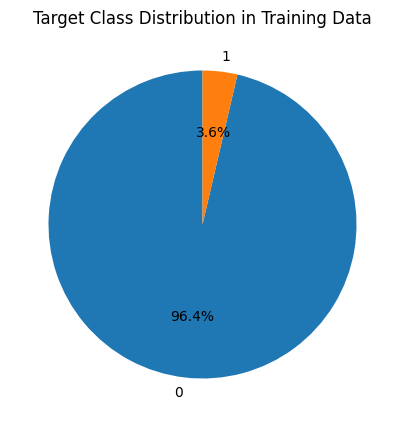

In [22]:
counts = y.value_counts()

plt.figure(figsize=(5,5))
plt.pie(counts, labels=counts.index, autopct="%1.1f%%", startangle=90)
plt.title("Target Class Distribution in Training Data")
plt.show()

# counts.plot(kind="bar", title="Target Count", rot=0)
# plt.show()

#### The target variable is highly imbalanced, with the positive class representing only about 3.6%, making AUC and Gini more appropriate than accuracy.

## Exploratory Data Analysis

### Missing Values Analsyis

Missing value counts of features:


feature_39    329010
feature_8     213303
feature_45     86301
feature_38     34128
feature_28      9242
feature_12      4638
feature_31       464
feature_34       173
feature_35        83
feature_15        67
feature_9          5
feature_42         4
feature_29         1
feature_2          0
feature_6          0
feature_5          0
feature_3          0
feature_1          0
feature_18         0
feature_17         0
feature_16         0
feature_14         0
feature_11         0
feature_13         0
feature_7          0
feature_10         0
feature_4          0
feature_26         0
feature_24         0
feature_25         0
feature_19         0
feature_20         0
feature_21         0
feature_22         0
feature_33         0
feature_32         0
feature_27         0
feature_30         0
feature_23         0
feature_37         0
feature_40         0
feature_36         0
feature_41         0
feature_43         0
feature_44         0
feature_46         0
feature_47         0
feature_48   

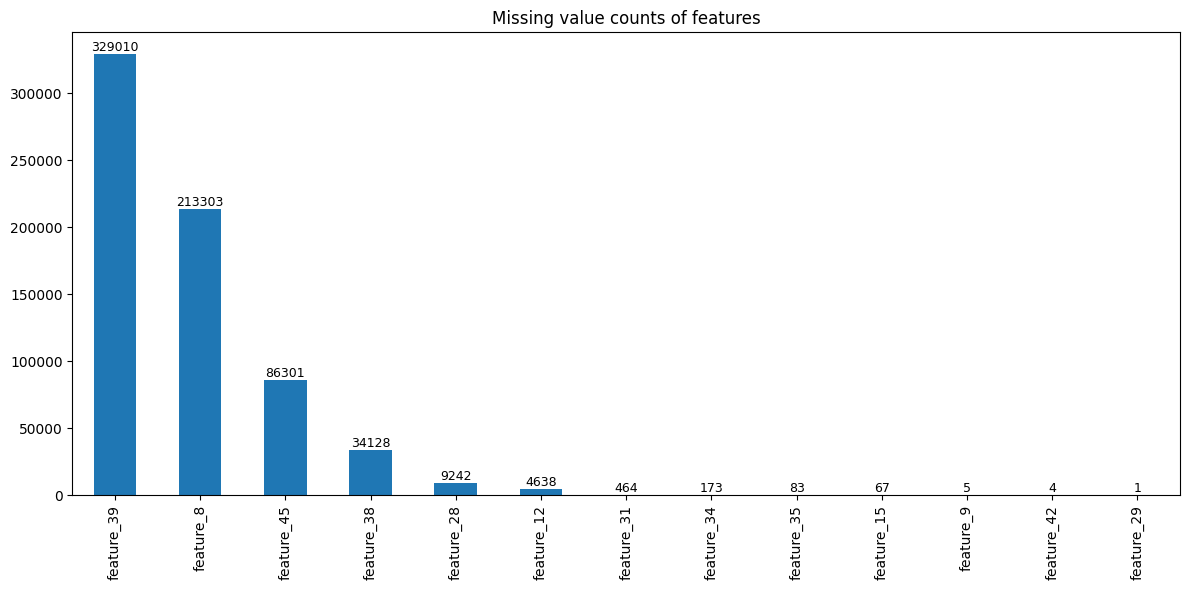

In [23]:
missing = X.isna().sum().sort_values(ascending=False)

print("Missing value counts of features:")
display(missing)

ax = missing[missing > 0].head(15).plot(
    kind="bar",
    figsize=(12, 6),
    title="Missing value counts of features"
)

# Annotate each bar with count
for p in ax.patches:
    ax.annotate(
        int(p.get_height()),
        (p.get_x() + p.get_width() / 2, p.get_height()),
        ha='center',
        va='bottom',
        fontsize=9
    )

plt.tight_layout()
plt.show()

#### Majority of features are complete: Over 80% of features have no missing values, reducing the need for aggressive global imputation.

#### Long-tail missing pattern: Several features show progressively fewer missing values, indicating heterogeneous data generation processes.

#### Missing values are highly concentrated in a few features, that tree-based models can exploit as signal rather than noise. Hence they need to be handled gracefully.

### Unique Values Analysis

feature_8       2
feature_15      2
feature_28      2
feature_39      2
feature_42      2
feature_49      2
feature_3       3
feature_34      4
feature_31      5
feature_12      7
feature_23     10
feature_35     12
feature_7      18
feature_25    104
dtype: int64

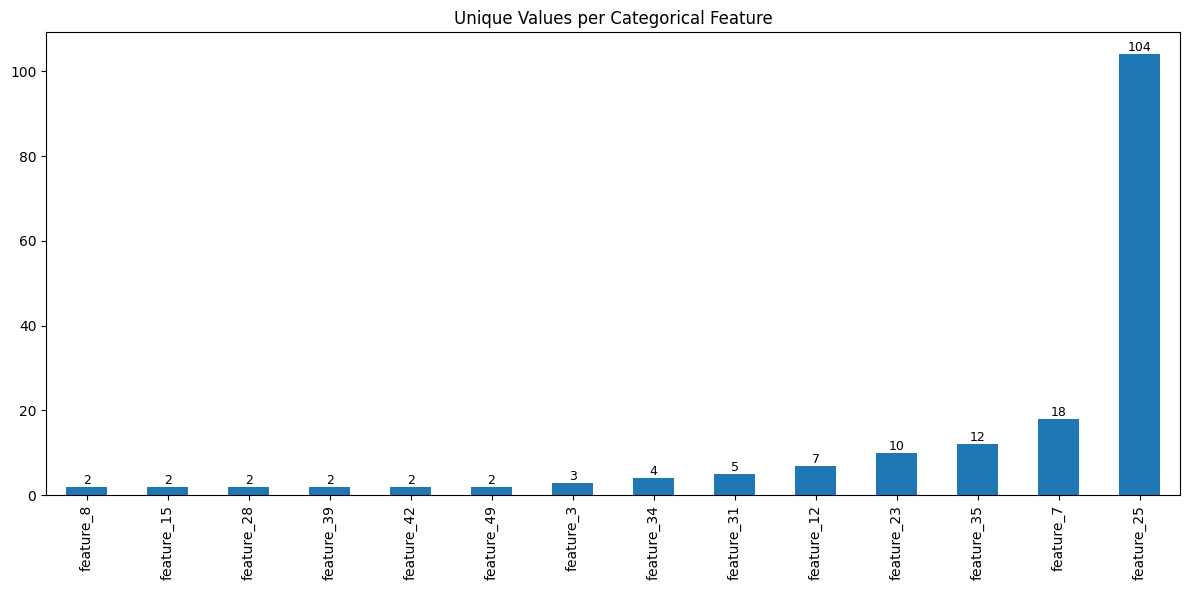

In [24]:
unique_vals = X[cat_features].nunique().sort_values()

display(unique_vals)

ax = unique_vals.plot(
    kind="bar",
    figsize=(12, 6),
    title="Unique Values per Categorical Feature"
)

for p in ax.patches:
    ax.annotate(
        int(p.get_height()),
        (p.get_x() + p.get_width() / 2, p.get_height()),
        ha="center",
        va="bottom",
        fontsize=9
    )

plt.tight_layout()
plt.show()

#### Most of the categorical features have low caridnality, suggesting they behave like categorical or quasi-binary variables, which justifies treating them as categorical rather than numeric.

feature_9         4
feature_1         5
feature_26        8
feature_50        8
feature_43       10
feature_17       11
feature_13       11
feature_36       12
feature_47       14
feature_48       14
feature_33       15
feature_10       19
feature_40       20
feature_37       24
feature_2        26
feature_29      180
feature_38      843
feature_45     4974
feature_24    64133
dtype: int64

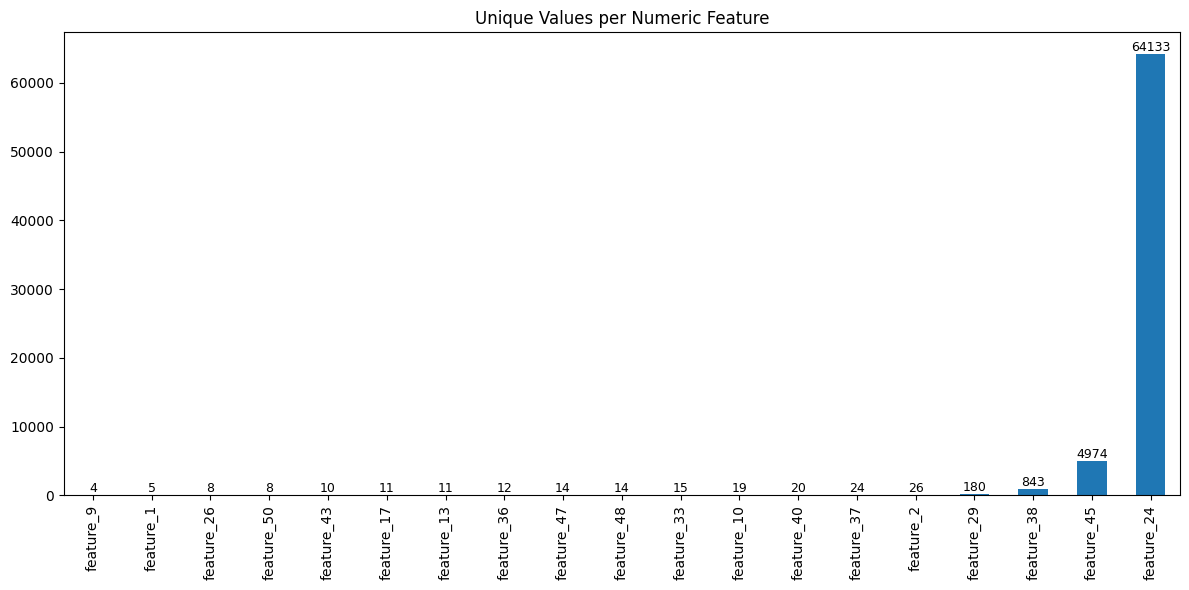

In [25]:
unique_vals = X[numeric_features].nunique().sort_values()

display(unique_vals)

ax = unique_vals.plot(
    kind="bar",
    figsize=(12, 6),
    title="Unique Values per Numeric Feature"
)

for p in ax.patches:
    ax.annotate(
        int(p.get_height()),
        (p.get_x() + p.get_width() / 2, p.get_height()),
        ha="center",
        va="bottom",
        fontsize=9
    )

plt.tight_layout()
plt.show()


#### Several numeric features have very low unique counts, indicating ordinal behavior, which tree-based models can naturally handle without explicit binning.

### Feature Distribution Plots

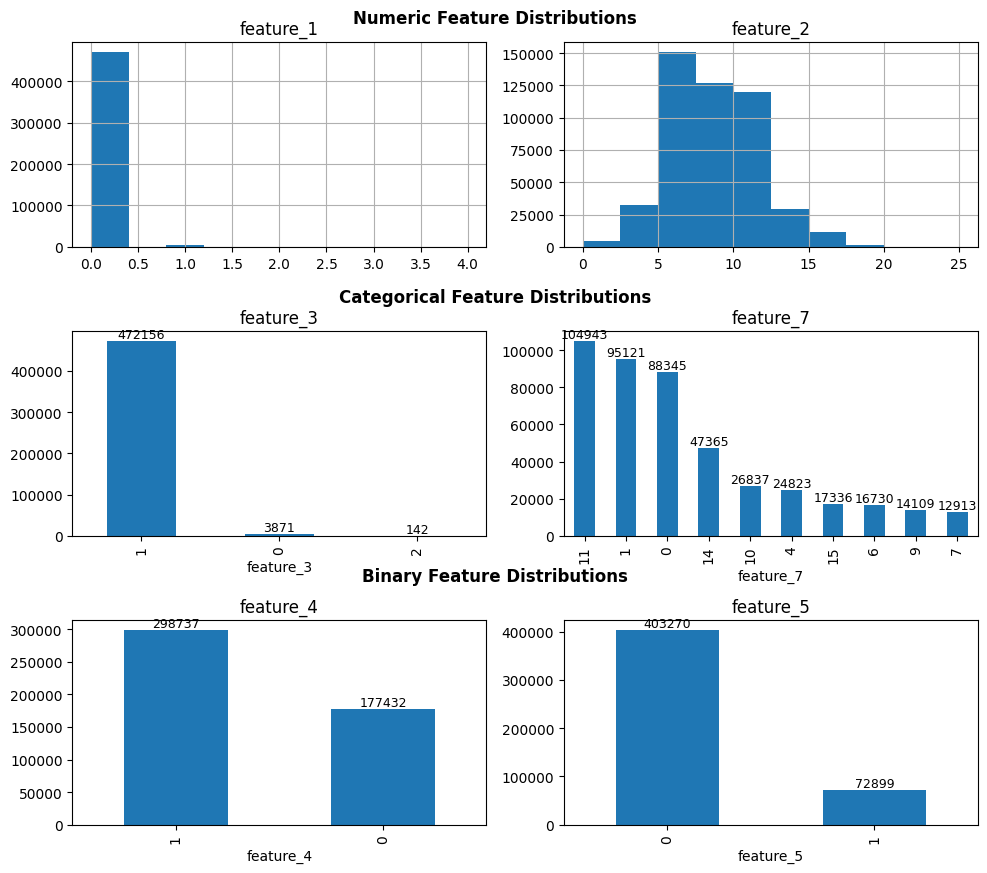

In [26]:
sample_numeric = numeric_features[:2]
sample_cat = cat_features[:2]
sample_binary = binary_features[:2]

fig, axes = plt.subplots(3, 2, figsize=(10, 9))

# Numeric
X[sample_numeric[0]].hist(ax=axes[0, 0])
axes[0, 0].set_title(sample_numeric[0])

X[sample_numeric[1]].hist(ax=axes[0, 1])
axes[0, 1].set_title(sample_numeric[1])

# Categorical 
ax_cat_0 = X[sample_cat[0]].value_counts().head(10).plot(kind="bar", ax=axes[1, 0])
axes[1, 0].set_title(sample_cat[0])

ax_cat_1 = X[sample_cat[1]].value_counts().head(10).plot(kind="bar", ax=axes[1, 1])
axes[1, 1].set_title(sample_cat[1])

# Binary 
ax_bin_0 = X[sample_binary[0]].value_counts().plot(kind="bar", ax=axes[2, 0])
axes[2, 0].set_title(sample_binary[0])

ax_bin_1 = X[sample_binary[1]].value_counts().plot(kind="bar", ax=axes[2, 1])
axes[2, 1].set_title(sample_binary[1])

# Annotate bars
for ax in [ax_cat_0, ax_cat_1, ax_bin_0, ax_bin_1]:
    for p in ax.patches:
        ax.annotate(
            int(p.get_height()),
            (p.get_x() + p.get_width() / 2, p.get_height()),
            ha="center",
            va="bottom",
            fontsize=9
        )

fig.text(0.5, 0.95, "Numeric Feature Distributions", ha="center", fontsize=12, weight="bold")
fig.text(0.5, 0.64, "Categorical Feature Distributions", ha="center", fontsize=12, weight="bold")
fig.text(0.5, 0.33, "Binary Feature Distributions", ha="center", fontsize=12, weight="bold")

plt.tight_layout(rect=[0, 0, 1, 0.97])
plt.show()


#### The sample distributions show strong skewness, discrete numeric values and imbalanced categorical and binary features, reinforcing the choice of tree-based models without scaling.

In [27]:
df_train.describe()

,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,feature_8,feature_9,feature_10,...,feature_42,feature_43,feature_44,feature_45,feature_46,feature_47,feature_48,feature_49,feature_50,target
count,476169.000000,476169.000000,476169.000000,476169.000000,476169.000000,476169.000000,476169.000000,262866.000000,476164.000000,476169.000000,...,476165.000000,476169.000000,476169.000000,389868.000000,476169.000000,476169.000000,476169.000000,476169.000000,476169.000000,476169.000000
mean,0.012162,8.436637,0.992169,0.627376,0.153095,0.349355,6.546621,0.526519,2.346662,0.438953,...,0.829946,0.610928,0.153086,0.894044,0.163929,2.872612,7.303182,0.832217,2.339035,0.036447
std,0.125724,2.905971,0.091468,0.483504,0.360079,0.476767,5.501513,0.499297,0.832222,0.404044,...,0.375681,0.287620,0.360071,0.345234,0.370212,1.695047,3.545386,0.373674,1.246078,0.187400
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.061237,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,6.000000,1.000000,0.000000,0.000000,0.000000,1.000000,0.000000,2.000000,0.200000,...,1.000000,0.400000,0.000000,0.633443,0.000000,2.000000,5.000000,1.000000,1.000000,0.000000
50%,0.000000,8.000000,1.000000,1.000000,0.000000,0.000000,7.000000,1.000000,3.000000,0.300000,...,1.000000,0.700000,0.000000,0.801561,0.000000,3.000000,7.000000,1.000000,2.000000,0.000000
75%,0.000000,10.000000,1.000000,1.000000,0.000000,1.000000,11.000000,1.000000,3.000000,0.600000,...,1.000000,0.900000,0.000000,1.083974,0.000000,4.000000,10.000000,1.000000,3.000000,0.000000
max,4.000000,25.000000,2.000000,1.000000,1.000000,1.000000,17.000000,1.000000,3.000000,1.800000,...,1.000000,0.900000,1.000000,4.037945,1.000000,13.000000,13.000000,1.000000,7.000000,1.000000


### Feature Correlation

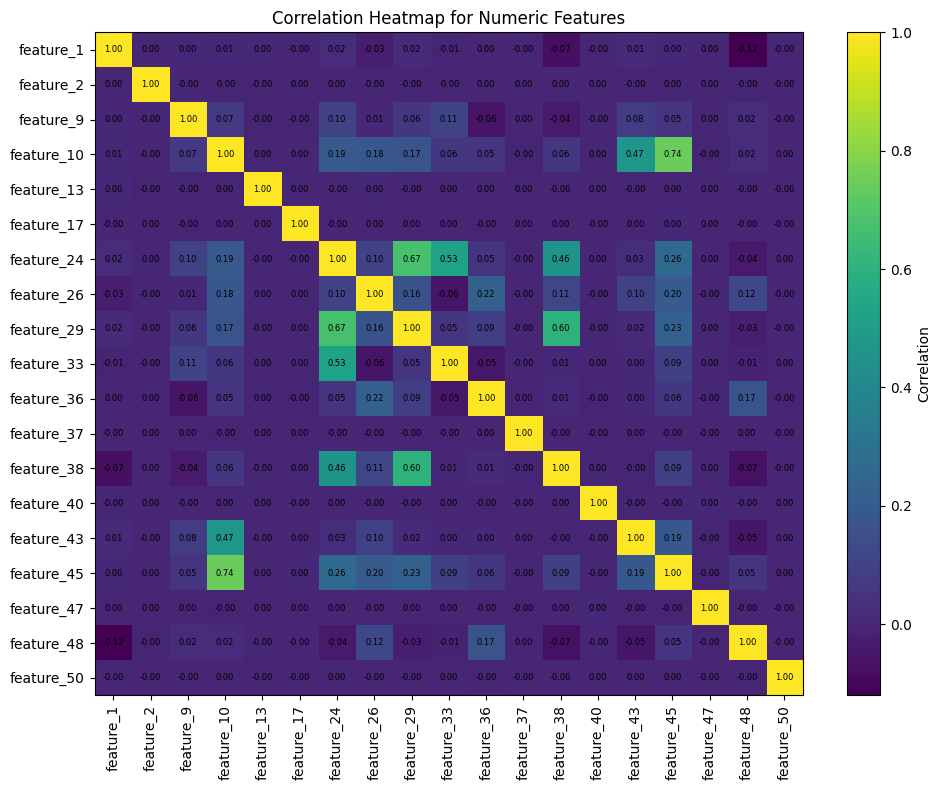

In [28]:
corr = X[numeric_features].corr()

plt.figure(figsize=(10, 8))
plt.imshow(corr, aspect="auto")
plt.colorbar(label="Correlation")

for i in range(len(corr)):
    for j in range(len(corr)):
        plt.text(
            j, i,
            f"{corr.iloc[i, j]:.2f}",
            ha="center",
            va="center",
            fontsize=6
        )

plt.xticks(range(len(corr.columns)), corr.columns, rotation=90)
plt.yticks(range(len(corr.columns)), corr.columns)

plt.title("Correlation Heatmap for Numeric Features")
plt.tight_layout()
plt.show()


##### The correlation heatmap shows that most numeric features have **low pairwise correlation**, indicating limited multicollinearity in the dataset. A few **moderate positive correlations** are visible among small groups of features, but no strongly correlated clusters dominate. This suggests that the numeric features largely capture **independent information**, which is favorable for tree-based models like LightGBM and CatBoost.  
##### As a result, explicit feature reduction based on correlation is **not necessary**, since removing features would likely discard useful information rather than reducing redundancy.


## Custom Metrics (AUC, Accuracy, Normalized Gini)

#### Why Ginni? 

- Works well with imbalanced data

- Rewards good probability ranking

- Standard metric in insurance risk modeling 


In [29]:
# Computes the raw Gini coefficient.
def gini_calculation(actual, pred):

    assert len(actual) == len(pred)
    arr = np.asarray(np.c_[actual, pred, np.arange(len(actual))], dtype=np.float64)
    arr = arr[np.lexsort((arr[:, 2], -arr[:, 1]))]

    total_pos = arr[:, 0].sum()
    gini_sum = arr[:, 0].cumsum().sum() / total_pos
    gini_sum -= (len(actual) + 1) / 2.0

    return gini_sum / len(actual)

# Returns a dictionary of evaluation metrics.
def get_metrics(y_true, y_pred_proba, model_name):

    auc = roc_auc_score(y_true, y_pred_proba)
    acc = accuracy_score(y_true, (y_pred_proba > 0.5).astype(int))

    raw_gini = gini_calculation(y_true, y_pred_proba)
    perfect_gini = gini_calculation(y_true, y_true)
    norm_gini = raw_gini / perfect_gini

    return {
        "Model": model_name,
        "AUC": auc,
        "Accuracy": acc,
        "Norm Gini": norm_gini
    }

### Challenges in Problem Statement

- High class imbalance
- Mixed feature types
- Missing values
- Unknown feature semantics
- Metric based on ranking (Gini)

## CatBoost Model 

CatBoost is a boosting library that specializes in automatically handling categorical features and reducing overfitting through symmetric trees and ordered boosting.

CatBoost is used to handle categorical features directly without one-hot encoding.  

Categorical columns are cast to string and missing values are filled with `"missing"`.  
Numeric features are imputed using median values to handle missing data.

The model is trained with **1000 iterations**, **tree depth = 7** and a **learning rate of 0.03**.  
Class imbalance is handled using **scale_pos_weight = 5.14**. 

$$scale\_pos\_weight = \sqrt{\frac{N_{non\_claims}}{N_{claims}}}$$


Model optimization is performed using the **AUC** metric with **early stopping after 50 rounds** based on validation performance.



In [30]:
def run_catboost(X_train, y_train, X_val, y_val, X_test, cat_features):
    print("Running CatBoost...")

    # Copy to avoid modifying originals
    X_tr, X_v, X_t = X_train.copy(), X_val.copy(), X_test.copy()

    # Categorical preprocessing
    for col in cat_features:
        X_tr[col] = X_tr[col].astype(str).fillna("missing")
        X_v[col]  = X_v[col].astype(str).fillna("missing")
        X_t[col]  = X_t[col].astype(str).fillna("missing")

    # Numeric preprocessing
    num_cols = [c for c in X_tr.columns if c not in cat_features]
    imputer = SimpleImputer(strategy="median")

    X_tr[num_cols] = imputer.fit_transform(X_tr[num_cols])
    X_v[num_cols]  = imputer.transform(X_v[num_cols])
    X_t[num_cols]  = imputer.transform(X_t[num_cols])

    cat_idx = [X_tr.columns.get_loc(c) for c in cat_features]

    model = CatBoostClassifier(
        iterations=1000,
        depth=7,
        learning_rate=0.03,
        scale_pos_weight=5.14,
        eval_metric="AUC",
        random_seed=RANDOM_STATE,
        verbose=50,                # print every 50 iters
        allow_writing_files=False
    )

    model.fit(
        X_tr, y_train,
        cat_features=cat_idx,
        eval_set=(X_v, y_val),
        early_stopping_rounds=50
    )
    
    print("Trained CatBoost.")

    return (
        model,
        model.predict_proba(X_v)[:, 1],
        model.predict_proba(X_t)[:, 1]
    )

## LightGBM Model 

LightGBM is used for efficient gradient boosting on numeric features with strong performance on large, imbalanced datasets. 

Categorical features are transformed using **target encoding**, where each category is replaced by the mean target value computed from the training data. Missing or unseen categories are filled using the global target mean.

After encoding, original categorical columns are dropped and remaining missing values are filled with **-1**.

The model is trained with **1000 boosting rounds**, a **learning rate of 0.02**, **num_leaves = 20** and **max_depth = 5**.  
Optimization is performed using the **AUC** metric with **early stopping after 50 rounds** based on validation performance.




In [ ]:
def run_lightgbm(X_train, y_train, X_val, y_val, X_test, cat_features):
    print("Running LightGBM...")

    X_tr, X_v, X_t = X_train.copy(), X_val.copy(), X_test.copy()

    # Target encoding
    for col in cat_features:
        means = y_train.groupby(X_train[col]).mean()
        global_mean = y_train.mean()

        X_tr[f"{col}_te"] = X_tr[col].map(means).fillna(global_mean)
        X_v[f"{col}_te"]  = X_v[col].map(means).fillna(global_mean)
        X_t[f"{col}_te"]  = X_t[col].map(means).fillna(global_mean)

    X_tr = X_tr.drop(columns=cat_features).fillna(-1)
    X_v  = X_v.drop(columns=cat_features).fillna(-1)
    X_t  = X_t.drop(columns=cat_features).fillna(-1)

    params = {
        "objective": "binary",
        "metric": "auc",
        "learning_rate": 0.02,
        "num_leaves": 20,
        "max_depth": 5,
        "verbosity": -1,
        "seed": RANDOM_STATE,
    }

    dtrain = lgb.Dataset(X_tr, label=y_train)
    dval   = lgb.Dataset(X_v, label=y_val, reference=dtrain)

    model = lgb.train(
    params,
    dtrain,
    num_boost_round=1000,
    valid_sets=[dval],
    callbacks=[
        lgb.early_stopping(50),
        lgb.log_evaluation(50)   # print every 50 iters
    ]
)
    
    print("Trained LightGBM.")

    return model, model.predict(X_v), model.predict(X_t)

## Train-Test Split

Creating a stratified validation set to prevent class-imbalance distortion, ensuring **no data leakage**.

In [32]:
X_train, X_val, y_train, y_val = train_test_split(
    X, y,
    test_size=VAL_SIZE,
    stratify=y,
    random_state=RANDOM_STATE
)

In [33]:
print(f"Train size: {len(X_train)} | Validation size: {len(X_val)}")

train_ratio = {
    int(k): f"{v*100:.2f}%"
    for k, v in y_train.value_counts(normalize=True).items()
}

val_ratio = {
    int(k): f"{v*100:.2f}%"
    for k, v in y_val.value_counts(normalize=True).items()
}

print("Train target ratio:", train_ratio)
print("Validation target ratio:", val_ratio)


Train size: 428552 | Validation size: 47617
Train target ratio: {0: '96.36%', 1: '3.64%'}
Validation target ratio: {0: '96.35%', 1: '3.65%'}


## Training Models

In [34]:
cb_model, cb_val, cb_test = run_catboost(
    X_train, y_train,
    X_val, y_val,
    X_test_raw,
    cat_features
)

Running CatBoost...
0:	test: 0.5732887	best: 0.5732887 (0)	total: 627ms	remaining: 10m 26s
50:	test: 0.6253647	best: 0.6256057 (46)	total: 20.1s	remaining: 6m 14s
100:	test: 0.6345905	best: 0.6345905 (100)	total: 43s	remaining: 6m 22s
150:	test: 0.6395216	best: 0.6395309 (146)	total: 1m 6s	remaining: 6m 11s
200:	test: 0.6420010	best: 0.6420270 (199)	total: 1m 29s	remaining: 5m 57s
250:	test: 0.6429719	best: 0.6429975 (249)	total: 1m 53s	remaining: 5m 38s
300:	test: 0.6443782	best: 0.6443807 (299)	total: 2m 19s	remaining: 5m 23s
350:	test: 0.6456337	best: 0.6456337 (350)	total: 2m 45s	remaining: 5m 5s
400:	test: 0.6462060	best: 0.6462699 (395)	total: 3m 11s	remaining: 4m 46s
450:	test: 0.6467514	best: 0.6468689 (430)	total: 3m 39s	remaining: 4m 26s
500:	test: 0.6475225	best: 0.6475225 (500)	total: 4m 5s	remaining: 4m 4s
550:	test: 0.6474553	best: 0.6478330 (515)	total: 4m 32s	remaining: 3m 42s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.6478330237
bestIteration =

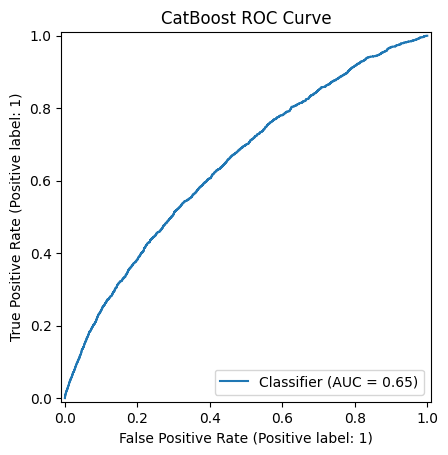

In [35]:
RocCurveDisplay.from_predictions(y_val, cb_val)
plt.title("CatBoost ROC Curve")
plt.show()

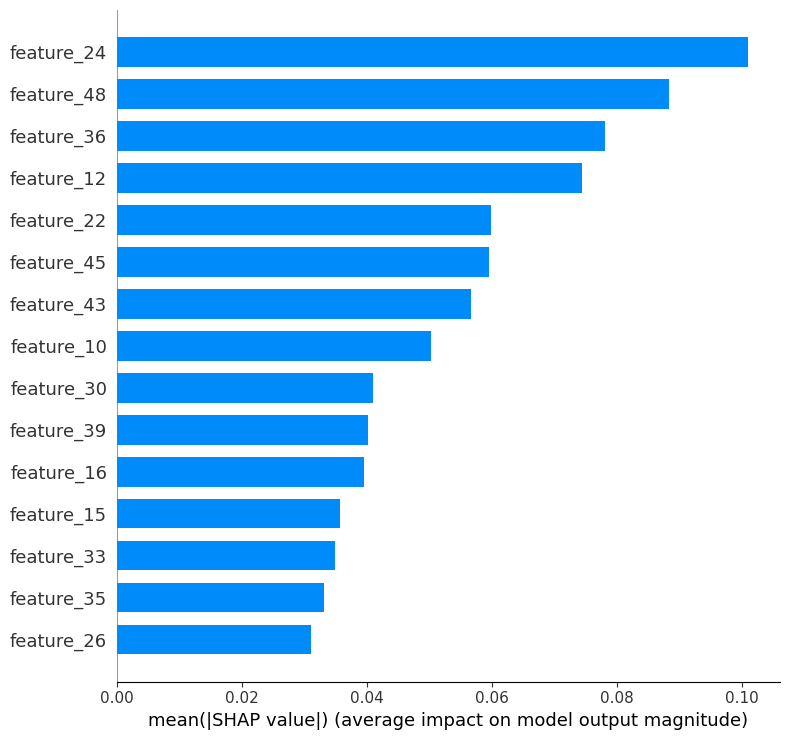

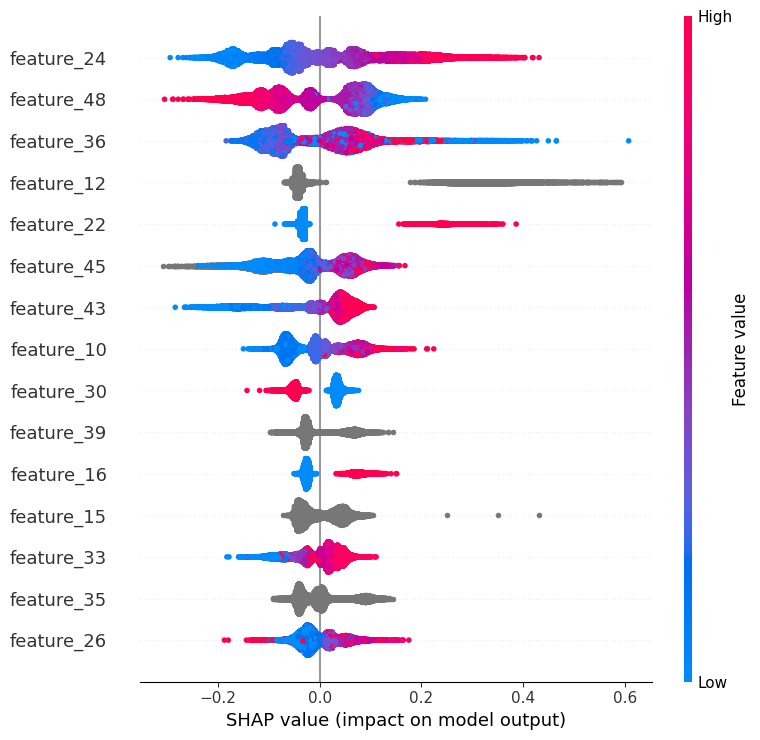

In [36]:
shap.initjs()

X_cb_shap = X_val.copy()

for col in cat_features:
    X_cb_shap[col] = X_cb_shap[col].astype(str).fillna("missing")

explainer = shap.TreeExplainer(cb_model)

shap_values = explainer.shap_values(X_cb_shap)

shap.summary_plot(
    shap_values,
    X_cb_shap,
    plot_type="bar",
    max_display=15
)

shap.summary_plot(
    shap_values,
    X_cb_shap,
    max_display=15
)

- The model demonstrates reliable ranking performance, which is appropriate for a highly imbalanced classification problem.  
- Prediction behavior is conservative, prioritizing correct ranking over raw class accuracy.  
- Feature importance and SHAP analysis indicate that the model relies on a limited set of strong signals rather than noise.  
- Learned relationships are non-linear and consistent across the validation data.  
- Early stopping confirms stable training and good generalization to unseen data.


In [37]:
lgb_model, lgb_val, lgb_test = run_lightgbm(
    X_train, y_train,
    X_val, y_val,
    X_test_raw,
    cat_features
)

Running LightGBM...
Training until validation scores don't improve for 50 rounds
[50]	valid_0's auc: 0.630903
[100]	valid_0's auc: 0.638787
[150]	valid_0's auc: 0.642516
[200]	valid_0's auc: 0.645106
[250]	valid_0's auc: 0.64633
[300]	valid_0's auc: 0.64654
[350]	valid_0's auc: 0.646944
[400]	valid_0's auc: 0.647031
Early stopping, best iteration is:
[380]	valid_0's auc: 0.647187
Trained LightGBM.


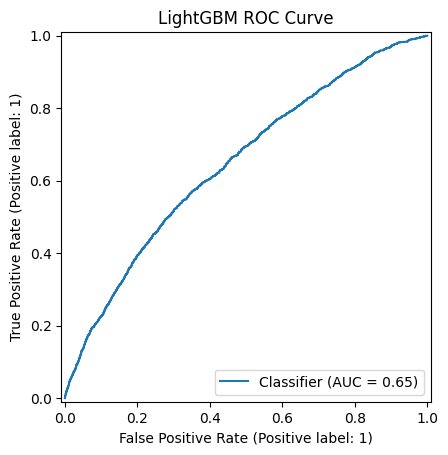

In [38]:
RocCurveDisplay.from_predictions(y_val, lgb_val)
plt.title("LightGBM ROC Curve")
plt.show()

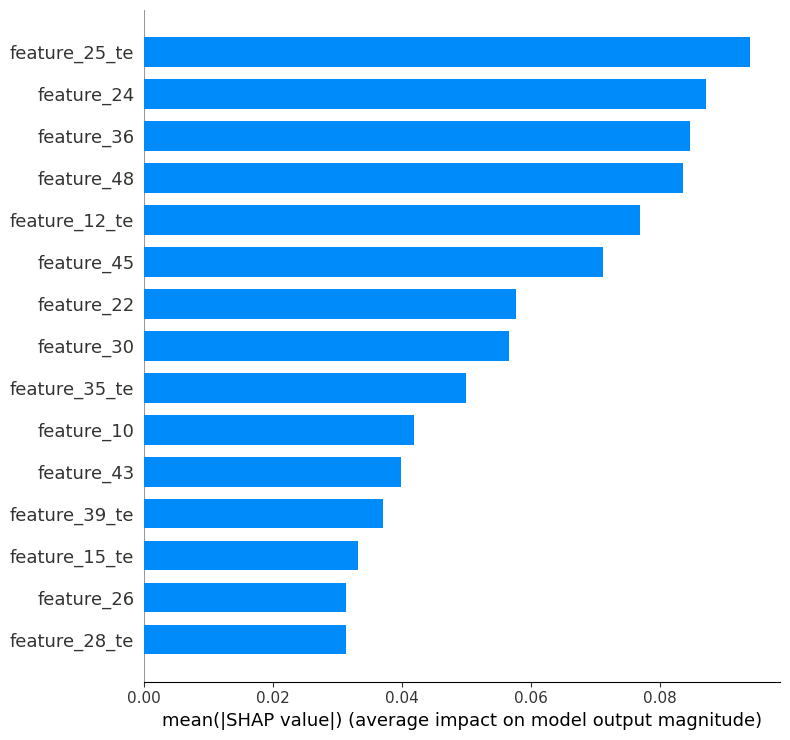

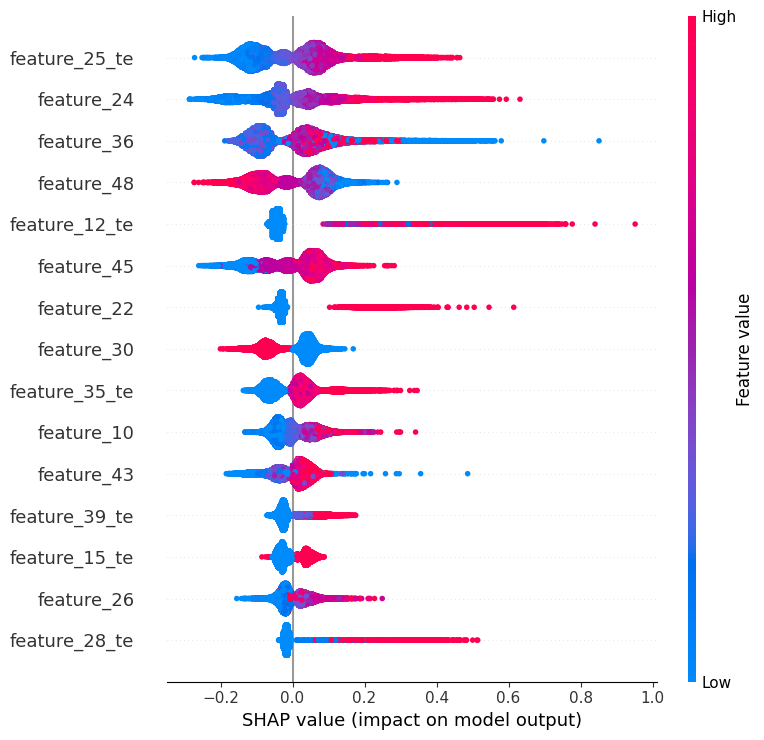

In [39]:
X_lgb_shap = X_val.copy()

for col in cat_features:
    means = y_train.groupby(X_train[col]).mean()
    global_mean = y_train.mean()
    X_lgb_shap[f"{col}_te"] = X_lgb_shap[col].map(means).fillna(global_mean)

X_lgb_shap = X_lgb_shap.drop(columns=cat_features).fillna(-1)

explainer_lgb = shap.TreeExplainer(lgb_model)
shap_values_lgb = explainer_lgb.shap_values(X_lgb_shap)

# Global importance
shap.summary_plot(
    shap_values_lgb,
    X_lgb_shap,
    plot_type="bar",
    max_display=15
)

# Beeswarm
shap.summary_plot(
    shap_values_lgb,
    X_lgb_shap,
    max_display=15
)


- The model achieves comparable ranking performance to CatBoost, confirming consistent signal extraction from the data.  
- Training converges smoothly with early stopping, indicating stable learning without overfitting.  
- Feature importance and SHAP results show reliance on a compact set of strong predictors, particularly target-encoded features.  
- SHAP distributions reflect non-linear effects and interaction patterns captured by the model.  
- Overall behavior complements CatBoost, making it well suited for ensembling.


### Model Probabilities Correlation

In [40]:
X_val_cb = X_val.copy()

for col in cat_features:
    X_val_cb[col] = X_val_cb[col].astype(str)

cat_preds = cb_model.predict_proba(X_val_cb)[:, 1]
lgb_preds = lgb_model.predict(X_val)

pearson = np.corrcoef(lgb_preds, cat_preds)[0, 1]
spearman, _ = spearmanr(lgb_preds, cat_preds)

print(f"Pearson correlation: {pearson:.4f}")
print(f"Spearman rank correlation: {spearman:.4f}")

Pearson correlation: 0.1325
Spearman rank correlation: 0.1495


The Pearson (0.14) and Spearman (0.16) correlations between LightGBM and CatBoost predictions are low, indicating that the two models produce substantially different probability rankings. This diversity confirms complementary ranking errors, which explains the need for ensembling their predictions, which leads to improved Normalized Gini and better generalization.

### Ensemble & Validation Metrics

We had iterated over several weight combinations for LightGBM and CatBoost. The best Gini score was obtained at - 60% CatBoost and 40% LightGBM weights.

In [41]:
ens_val  = 0.6 * cb_val  + 0.4 * lgb_val
ens_test = 0.6 * cb_test + 0.4 * lgb_test

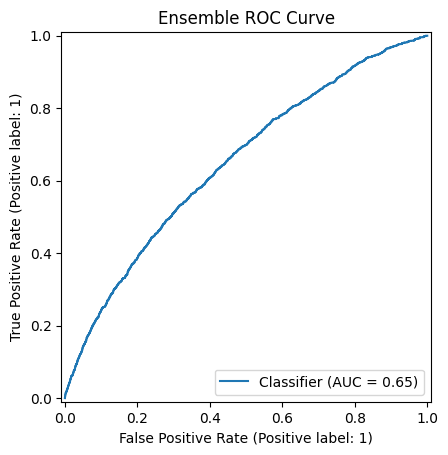

In [ ]:
RocCurveDisplay.from_predictions(y_val, ens_val)
plt.title("Ensemble ROC Curve")
plt.show()

Ensemble SHAP is not required here since SHAP is best interpreted at the individual model level and the ensemble is a simple weighted average of their predictions.


       VALIDATION METRICS on Test split (Unseen Data)       
Model           | AUC        | Accuracy   | Norm Gini 
------------------------------------------------------------
CatBoost        | 0.64783    | 0.96327    | 0.29567
LightGBM        | 0.64719    | 0.96356    | 0.29437
Ensemble        | 0.64848    | 0.96354    | 0.29696
------------------------------------------------------------


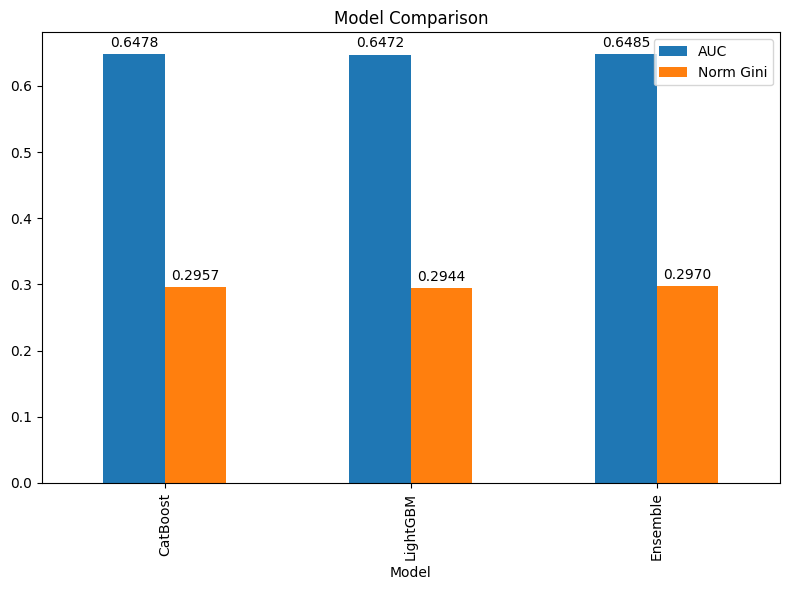

In [43]:
print("\n" + "=" * 60)
print(f"{'VALIDATION METRICS on Test split (Unseen Data)':^60}")
print("=" * 60)
print(f"{'Model':<15} | {'AUC':<10} | {'Accuracy':<10} | {'Norm Gini':<10}")
print("-" * 60)

results = [
    get_metrics(y_val, cb_val,  "CatBoost"),
    get_metrics(y_val, lgb_val, "LightGBM"),
    get_metrics(y_val, ens_val, "Ensemble"),
]

for r in results:
    print(f"{r['Model']:<15} | {r['AUC']:.5f}    | {r['Accuracy']:.5f}    | {r['Norm Gini']:.5f}")

print("-" * 60)

metrics_df = pd.DataFrame(results).set_index("Model")

ax = metrics_df[["AUC", "Norm Gini"]].plot(
    kind="bar",
    figsize=(8,6),
    title="Model Comparison"
)

for container in ax.containers:
    ax.bar_label(container, fmt="%.4f", padding=3)

plt.tight_layout()
plt.show()

### Observation

#### The ensemble leverages the expertise of CatBoost on categorical features and LightGBM on numeric patterns, resulting in a higher Normalized Gini. This leads to stronger ranking performance and better generalization on unseen data.

## Create Submission File


In [44]:
submission = pd.DataFrame({
    "id": test_ids,
    "probability": ens_test
})

submission.to_csv(SUBMISSION_FILE, index=False)
print(f"Submission saved to: {SUBMISSION_FILE}")

Submission saved to: submission.csv
